# Machine Learning - Presentation - Team 6

### Team Members - 
##### (1) Ganesh Vasant
##### (2) Abhishek Kumar Singh
##### (3) Dinu Thomas
##### (4) Charithra Chandrashekar

### Topic - Prediction of bike rental service in a large metropolitan city

![Image](https://www.icebike.org/wp-content/uploads/2015/08/bike-rental-shop-14716686.jpg)

In [1]:
# type your code here
# type your code here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# import various functions from statsmodel to perform linear regression
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse

# import various functions from scipy
from scipy import stats
from scipy.stats import shapiro

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# import function to perform linear regression
from sklearn.linear_model import LinearRegression


# import functions to perform feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE

import datetime

In [3]:
bikeData = pd.read_csv('SeoulBikeData.csv', encoding= 'unicode_escape')

In [4]:
bikeData.head(5)

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [5]:
bikeData.describe(include='object')

Date Seasons     Holiday Functioning Day
count         8760    8760        8760            8760
unique         365       4           2               2
top     30/09/2018  Summer  No Holiday             Yes
freq            24    2208        8328            8465

In [6]:
bikeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [7]:
bikeData['Hour'].describe()

count    8760.000000
mean       11.500000
std         6.922582
min         0.000000
25%         5.750000
50%        11.500000
75%        17.250000
max        23.000000
Name: Hour, dtype: float64

Hour can be treated as categorical than a numeric.

### 1.1 Utility Functions

#### Convert hour into 3 buckets

In [204]:
#why x buckets

In [209]:
hour_avg = bikeData.groupby(by='Hour')['Rented Bike Count'].mean().reset_index()
#hour_avg

<AxesSubplot:xlabel='Hour', ylabel='Rented Bike Count'>

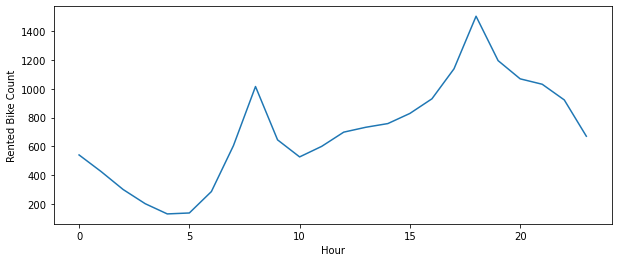

In [212]:
plt.figure(figsize=(10,4))
sns.lineplot(x=hour_avg['Hour'],y=hour_avg['Rented Bike Count'])

In [216]:
def convertHourBuckets(hour):
    hour = int(hour)
    if hour < 6:
        # low and decreasing
        return 'early_morning'
    elif hour < 9:
        return 'morning'
    elif hour < 16:
        return 'office_hours'
    elif hour < 20:
        return 'evening'    
    else:
        return 'night'

In [9]:
# Convert a date in the format 12/09/2018 to corresponding day = "Wednesday"
def convertDate2Day(date):
    return datetime.datetime.strptime(date, '%d/%m/%Y').strftime('%A')

# Convert a date in the format 12/09/2018 to weekday or weekend if weekend returns 1
# did not consider the middle east standard, as the data is from Korea
def convertDate2Weekend(date):
    day = convertDate2Day(date)
    if day in ["Sunday","Saturday"]:
        return 1
    return 0

#convertDate2Day('10/09/2021')
convertDate2Weekend('10/09/2021')

0

#### Scaling all together

In [10]:
def standardScale_dataframe(data,name_suffix = "_std"):
    std_scale = StandardScaler()
    variables = []
    numeric_df = data.select_dtypes(include=[np.number])
    for param in numeric_df.columns:
        param_name = param.strip()+name_suffix
        variables.append(param_name)
        if param_name not in (numeric_df.columns):
            print(param_name)
            numeric_df[param_name] = std_scale.fit_transform(data[[param]]) # returns z-scores of the values of the attribute
    return numeric_df,variables


#### Model Performance logged into a dataframe for comparison

In [11]:
# define a function to calculate MAPE
# pass the actual and predicted values as input to the function
# return the calculated MAPE 
def mape(actual, predicted):
    mape = np.abs((actual - predicted) / actual)
    mape = mape[~np.isnan(mape)]
    return ((mape) * 100).mean()

def model_metrics(result_df,model,name,remarks,datatype,y,y_hat):

    # calculate R-squared, Adjusted R-squared, MSE, RMSE, MAE and MAPE for full model
    # use 'rsquared' to calculate R-squared value
    # use 'rsquared_adj' to calculate Adjusted R-squared value
    # use 'mean_squared_error' to calculate MSE
    # use 'rmse' to calculate RMSE
    # use 'mean_absolute_error' to calculate MAE
    # use the defined function 'mape' to calculate MAPE
    residuals = model.resid

    MLR_full_model_metrics = pd.Series({'Model_Name': name,
                                        'Data_Type': datatype,
                                        'Remarks': remarks,
                                        'R-squared': model.rsquared,
                                        'Adj. R-squared': model.rsquared_adj,
                                        'Durbin_Watson':statsmodels.stats.stattools.durbin_watson(residuals, axis=0),
                                        'JB_Prob':statsmodels.stats.stattools.jarque_bera(residuals, axis=0)[1],
                                        'Condition_No': model.condition_number,
                                        'MSE': mean_squared_error(y, y_hat),
                                        'RMSE': np.sqrt(mean_squared_error(y, y_hat)),
                                        'MAE': mean_absolute_error(y, y_hat),
                                       })

    
    # append the values to the result table
    result_df = result_df[(result_df.Model_Name != name)]
    result_df = result_df.append(MLR_full_model_metrics, ignore_index = True)

    return result_df

In [12]:
#Utility function which wraps repeatedly used stuff for lr Models

In [13]:
def lr_model_experiment(df,target,exp_name,remarks,result_df,test_size=0.3,random_state = 123):
    X = df
    X = sm.add_constant(X)
    X = X.drop(target,axis = 1)
    print(X.columns)
    Y = df[target]
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=test_size,random_state=random_state) 
    lin_reg_model = sm.OLS(y_train,x_train).fit()
    
    y_test_predict = lin_reg_model.predict(x_test)

    out_df = model_metrics(result_df,lin_reg_model,exp_name+'_Test',remarks,"Test",y_test,y_test_predict)
    
    y_train_predict = lin_reg_model.predict(x_train)

    out_df = model_metrics(out_df,lin_reg_model,exp_name+'_Train',remarks,"Train",y_train,y_train_predict)
    return out_df,lin_reg_model,len(x_train)

### 1.2 Categorical Variables

In [218]:
#Convert the Hours into 3 buckets
bikeData['Hour_bkt'] = bikeData['Hour'].apply(lambda x : convertHourBuckets(x))

In [220]:
#Convert the Hours into 3 buckets
bikeData['Weekend'] = bikeData['Date'].apply(lambda x : convertDate2Weekend(x))

In [16]:
bikeData.Hour_bkt.unique()

array(['morning', 'day', 'night'], dtype=object)

In [221]:
#do the n-1 dummy encoding
bikeCatData_enc = pd.get_dummies(bikeData[['Seasons','Hour_bkt','Functioning Day','Holiday']],'',drop_first=True)
bikeCatData_enc.rename(columns={'_Yes':'FunctionDay'},inplace=True)
bikeCatData_enc.head(2)

_Spring  _Summer  _Winter  _evening  _morning  _night  _office_hours  \
0        0        0        1         0         0       0              0   
1        0        0        1         0         0       0              0   

   FunctionDay  _No Holiday  
0            1            1  
1            1            1

### 1.3 Take out all numbers

In [222]:
bikeData_num = bikeData.select_dtypes(include=[np.number])
#bikeData_num = bikeData_num.drop('Hour',axis = 1)

In [223]:
bikeData_feats = pd.concat([bikeData_num,bikeCatData_enc], axis=1)

In [224]:
bikeData_feats.describe()

Rented Bike Count         Hour  Temperature(�C)  Humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std           644.997468     6.922582        11.944825    20.362413   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    42.000000   
50%           504.500000    11.500000        13.700000    57.000000   
75%          1065.250000    17.250000        22.500000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(�C)  \
count       8760.000000       8760.000000                8760.000000   
mean           1.724909       1436.825799                   4.073813   
std            1.036300        608.298712                  13.060369   
min            0.000000         27.000000                 -30.600000   
25%            0.900000        940.000000                  -4.700000   
50%            1.500000       1698.000000                   5.100000   
75%            2.300000       2000.000000                  14.800000   
max            7.400000       2000.000000                  27.200000   

       Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)      Weekend  \
count              8760.000000   8760.000000    8760.000000  8760.000000   
mean                  0.569111      0.148687       0.075068     0.284932   
std                   0.868746      1.128193       0.436746     0.451408   
min                   0.000000      0.000000       0.000000     0.000000   
25%                   0.000000      0.000000       0.000000     0.000000   
50%                   0.010000      0.000000       0.000000     0.000000   
75%                   0.930000      0.000000       0.000000     1.000000   
max                   3.520000     35.000000       8.800000     1.000000   

           _Spring      _Summer      _Winter     _evening     _morning  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean      0.252055     0.252055     0.246575     0.166667     0.125000   
std       0.434217     0.434217     0.431042     0.372699     0.330738   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            _night  _office_hours  FunctionDay  _No Holiday  
count  8760.000000    8760.000000  8760.000000  8760.000000  
mean      0.166667       0.291667     0.966324     0.950685  
std       0.372699       0.454556     0.180404     0.216537  
min       0.000000       0.000000     0.000000     0.000000  
25%       0.000000       0.000000     1.000000     1.000000  
50%       0.000000       0.000000     1.000000     1.000000  
75%       0.000000       1.000000     1.000000     1.000000  
max       1.000000       1.000000     1.000000     1.000000

### 3. Multiple Linear Regression(MLR)

### 3.1 Understanding the Features Relations

<Figure size 1080x1080 with 0 Axes>

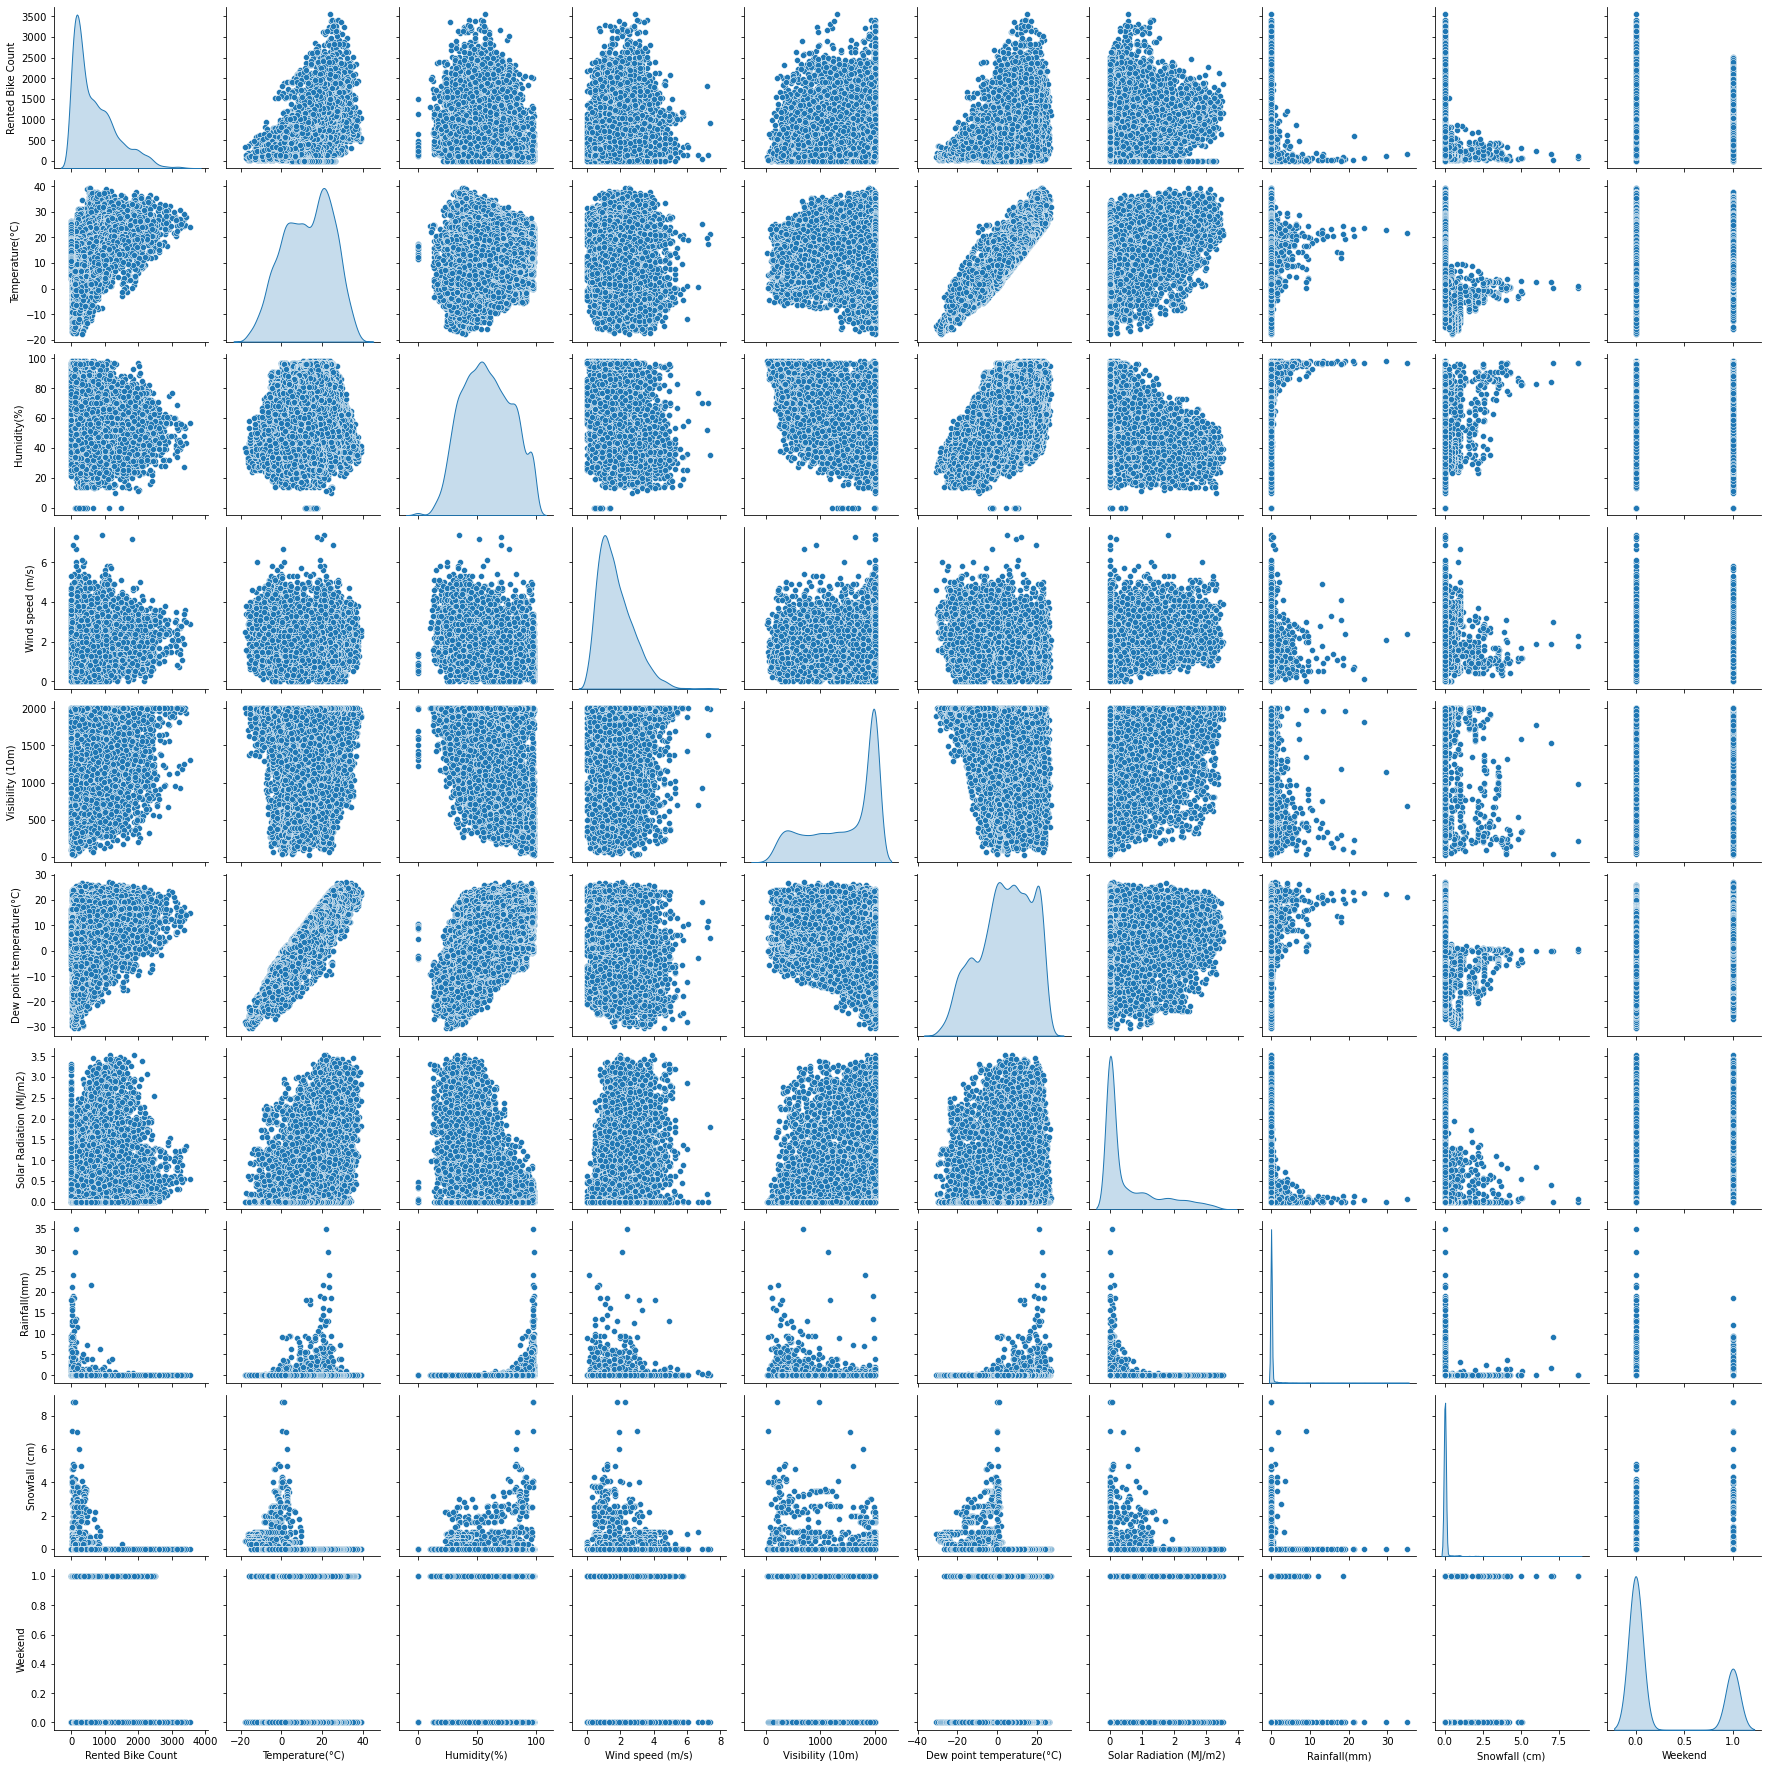

In [21]:
plt.figure(figsize=(15,15))
sns.pairplot(bikeData_num, diag_kind="kde")
#g.map_lower(sns.kdeplot, levels=4, color=".2")

**Observation1: some linearity is identified between Temperature and Dew point temperature**

In [22]:
corr = bikeData_feats.corr()

<AxesSubplot:>

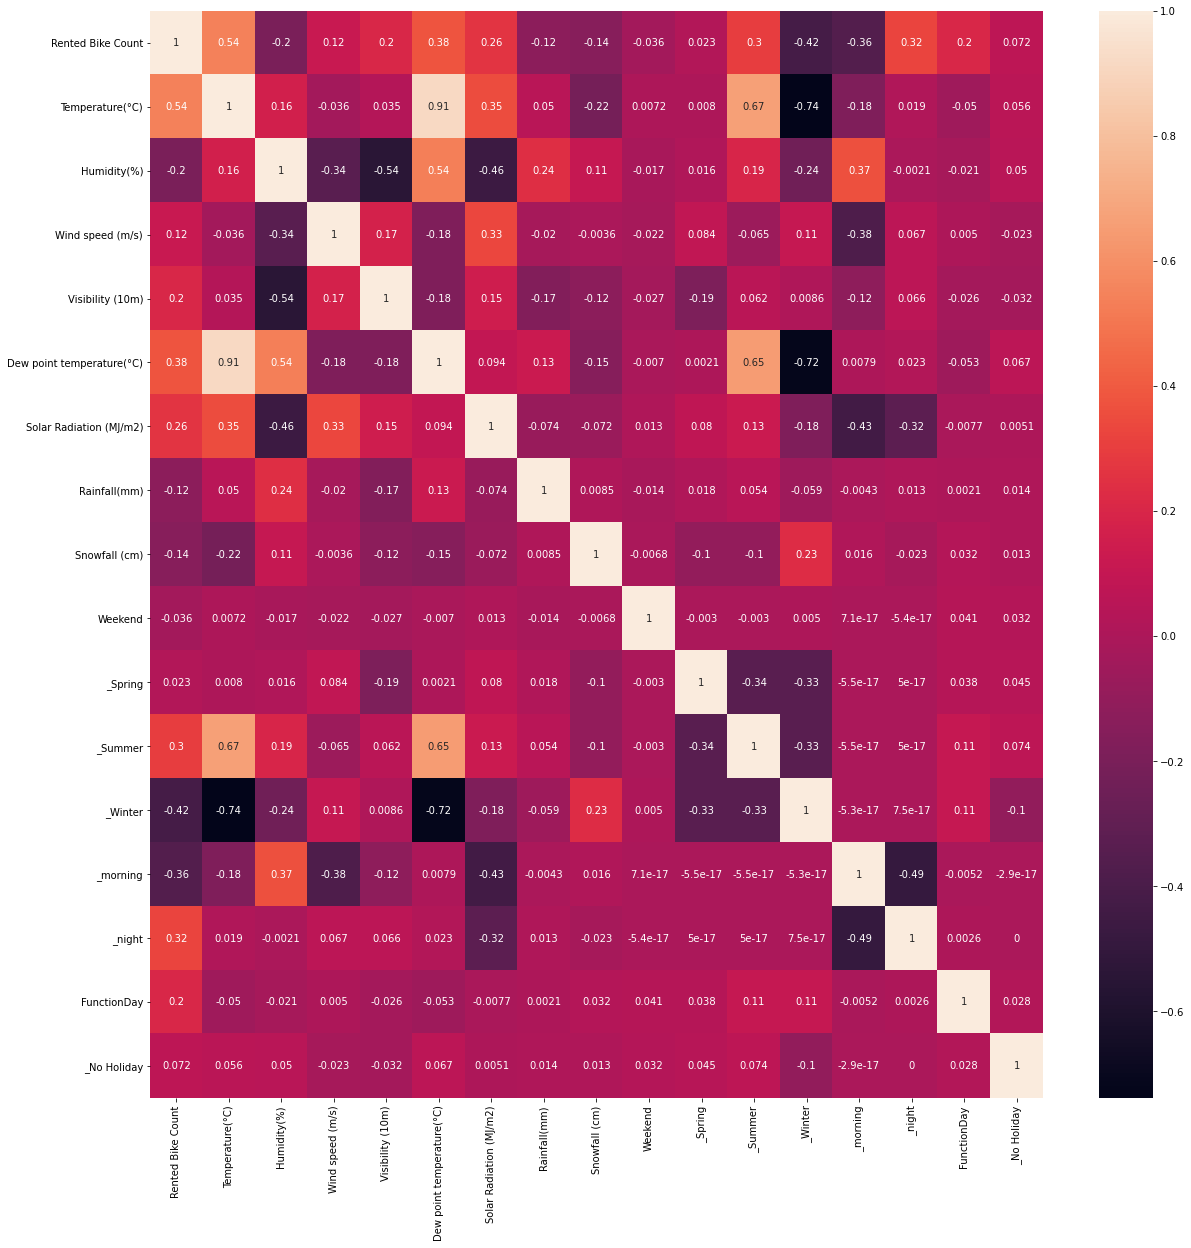

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)

<AxesSubplot:>

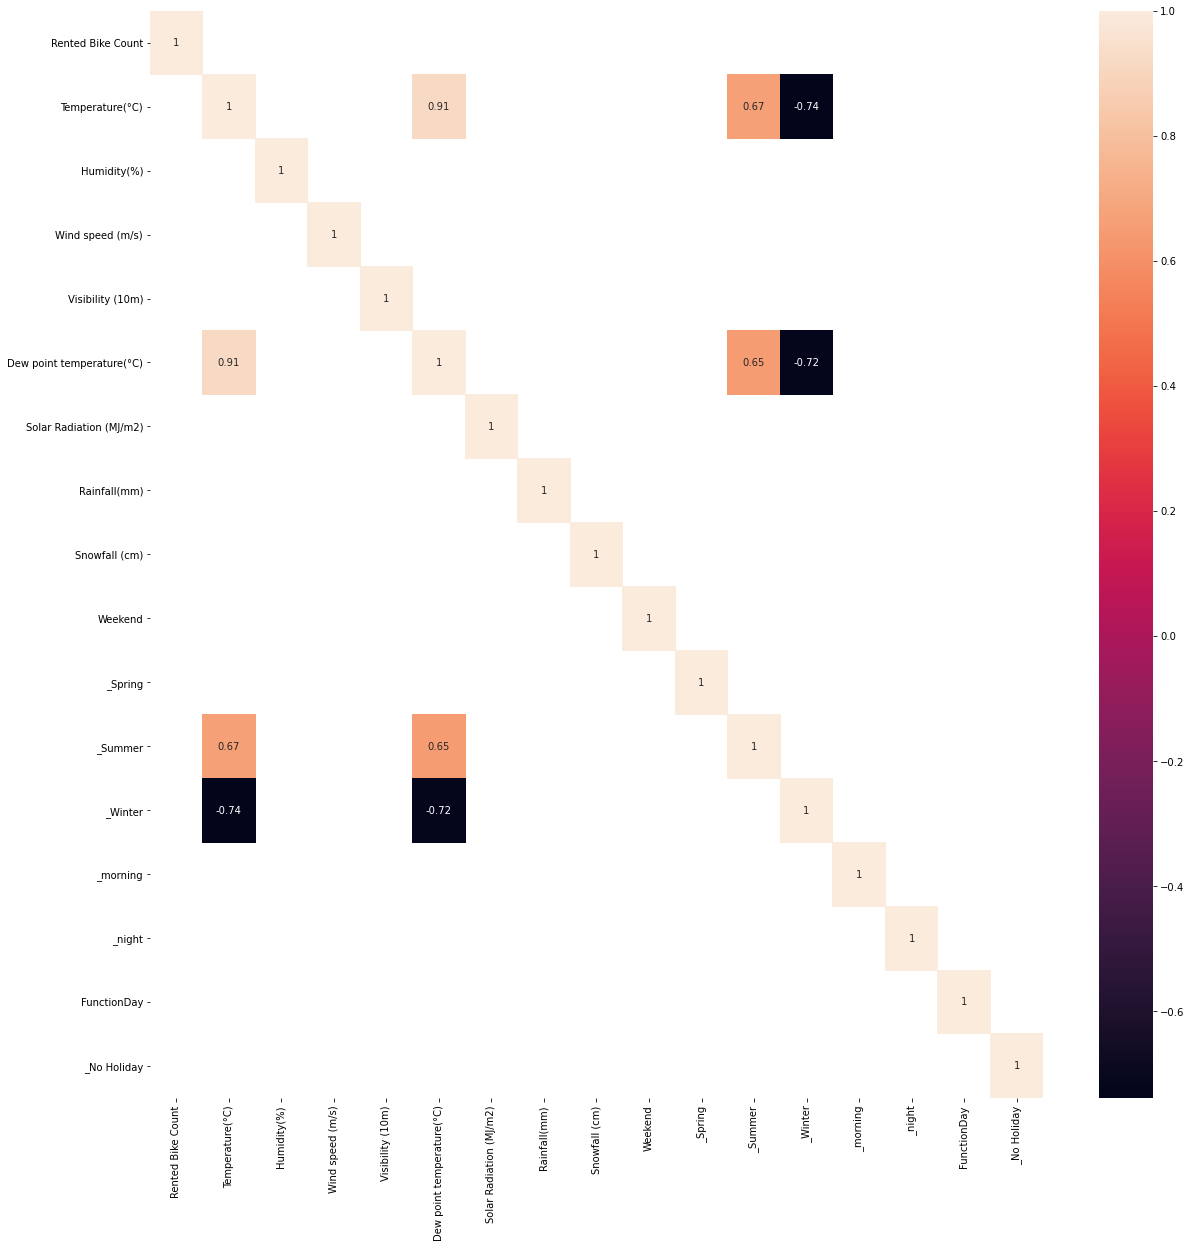

In [24]:
filter_corr = corr[np.abs(corr) > 0.6]
plt.figure(figsize=(20,20))
sns.heatmap(filter_corr, annot=True)

**Observation2: Significant linearity is identified between Temperature with Summer and Winter**

### 3.1.x Feature Elimination

In [225]:
bikeData_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(�C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(�C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Weekend                    8760 non-null   int64  
 11  _Spring                    8760 non-null   uint8  
 12  _Summer                    8760 non-null   uint8  
 13  _Winter                    8760 non-null   uint8

In [73]:
x_columns = ["Temperature(°C)", "Humidity(%)", "Wind speed (m/s)", "Visibility (10m)", "Dew point temperature(°C)", "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)", "Weekend", "_Summer", "_Winter", "_morning", "_night", "FunctionDay", "_No Holiday"]
y = bikeData_feats["Rented Bike Count"]

In [74]:
def get_stats():
    x = bikeData_feats[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())

get_stats()

                                 OLS Regression Results                                
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              2298.
Date:                Fri, 17 Sep 2021   Prob (F-statistic):                        0.00
Time:                        02:06:11   Log-Likelihood:                         -65542.
No. Observations:                8760   AIC:                                  1.311e+05
Df Residuals:                    8745   BIC:                                  1.312e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

#### Interpretation - 
Coefficients having p-values less than alpha are statistically significant. We would generally want to drop variables with a p-value greater than 0.05. As seen from the initial summary above, the least statistically significant variable are “Visibility (10m)” and "_morning" with a p-value of 0.968. Hence, we would want to drop “Safety” as a variable as shown below. The new summary is shown below as well.

In [75]:
x_columns.remove("Visibility (10m)")
x_columns.remove("_morning")

In [76]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              2651.
Date:                Fri, 17 Sep 2021   Prob (F-statistic):                        0.00
Time:                        02:07:09   Log-Likelihood:                         -65545.
No. Observations:                8760   AIC:                                  1.311e+05
Df Residuals:                    8747   BIC:                                  1.312e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

#### Interpretation - 
We are left with 13 variables. Since each of the p-values are below 0.05, all of these variables are said to be statistically significant.

In [81]:
# filter the numerical features in the dataset
bikeData_numeric_features_vif = bikeData_feats.select_dtypes(include=[np.number])

# display the first five observations
bikeData_numeric_features_vif.head()

Rented Bike Count  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254             -5.2           37               2.2   
1                204             -5.5           38               0.8   
2                173             -6.0           39               1.0   
3                107             -6.2           40               0.9   
4                 78             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm)  Weekend  _Spring  _Summer  _Winter  _morning  \
0           0.0            0.0        0        0        0        1         1   
1           0.0            0.0        0        0        0        1         1   
2           0.0            0.0        0        0        0        1         1   
3           0.0            0.0        0        0        0        1         1   
4           0.0            0.0        0        0        0        1         1   

   _night  FunctionDay  _No Holiday  
0       0            1            1  
1       0            1            1  
2       0            1            1  
3       0            1            1  
4       0            1            1

In [82]:
# create an empty dataframe to store the VIF for each variable
vif = pd.DataFrame()

# calculate VIF using list comprehension 
# use for loop to access each variable 
# calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
vif["VIF_Factor"] = [variance_inflation_factor(bikeData_numeric_features_vif.values, i) for i in range(bikeData_numeric_features_vif.shape[1])]

# create a column of variable names
vif["Features"] = bikeData_numeric_features_vif.columns

# sort the dataframe based on the values of VIF_Factor in descending order
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)

VIF_Factor                   Features
0    51.127943            Temperature(°C)
1    35.233846                FunctionDay
2    35.071641                Humidity(%)
3    34.930584  Dew point temperature(°C)
4    19.968102                _No Holiday
5    10.114359           Visibility (10m)
6     5.101613                   _morning
7     5.031320          Rented Bike Count
8     4.980288           Wind speed (m/s)
9     4.885496    Solar Radiation (MJ/m2)
10    4.530533                    _Winter
11    3.776002                     _night
12    3.589695                    _Summer
13    2.341625                    _Spring
14    1.423293                    Weekend
15    1.147736              Snowfall (cm)
16    1.116151               Rainfall(mm)

In [85]:
# for each numeric variable, calculate VIF and save it in a dataframe 'vif'

# use for loop to iterate the VIF function 
for ind in range(len(bikeData_numeric_features_vif.columns)):
    
    # create an empty dataframe
    vif = pd.DataFrame()

    # calculate VIF using list comprehension
    # use for loop to access each variable 
    # calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
    vif["VIF_Factor"] = [variance_inflation_factor(bikeData_numeric_features_vif.values, i) for i in range(bikeData_numeric_features_vif.shape[1])]

    # create a column of variable names
    vif["Features"] = bikeData_numeric_features_vif.columns

    # filter the variables with VIF greater than 10 and store it in a dataframe 'multi' 
    # one can choose the threshold other than 10 (it depends on the business requirements)
    multi = vif[vif['VIF_Factor'] > 10]
    
    # if dataframe 'multi' is not empty, then sort the dataframe by VIF values
    # if dataframe 'multi' is empty (i.e. all VIF <= 10), then print the dataframe 'vif' and break the for loop using 'break' 
    # 'by' sorts the data using given variable(s)
    # 'ascending = False' sorts the data in descending order
    if(multi.empty == False):
        df_sorted = multi.sort_values(by = 'VIF_Factor', ascending = False)
    else:
        print(vif)
        break
    
    # use if-else to drop the variable with the highest VIF
    # if  dataframe 'df_sorted' is not empty, then drop the first entry in the column 'Features' from the numeric variables
    # select the variable using 'iloc[]'
    # 'axis=1' drops the corresponding column
    #  else print the final dataframe 'vif' with all values after removal of variables with VIF less than 10  
    if (df_sorted.empty == False):
        bikeData_numeric_features_vif = bikeData_numeric_features_vif.drop(df_sorted.Features.iloc[0], axis=1)
    else:
        print(vif)

    VIF_Factor                   Features
0     3.833003          Rented Bike Count
1     4.541594           Wind speed (m/s)
2     6.480300           Visibility (10m)
3     3.920779  Dew point temperature(°C)
4     3.471569    Solar Radiation (MJ/m2)
5     1.076481               Rainfall(mm)
6     1.095136              Snowfall (cm)
7     1.374047                    Weekend
8     1.993009                    _Spring
9     3.142126                    _Summer
10    3.183768                    _Winter
11    3.331036                   _morning
12    3.210265                     _night


### 3.2 Model Building

In [228]:
Model_Features = list(bikeData_feats.columns)
Model_Features

['Rented Bike Count',
 'Hour',
 'Temperature(�C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(�C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Weekend',
 '_Spring',
 '_Summer',
 '_Winter',
 '_evening',
 '_morning',
 '_night',
 '_office_hours',
 'FunctionDay',
 '_No Holiday']

In [26]:
Target_Variable = ['Rented Bike Count']

**Make a result dataframe**

In [27]:
#Model Parameters to be compared in each experiments
cols = ['Model_Name','Data_Type','Remarks', 
        'R-squared','Adj. R-squared', 
        'Durbin_Watson', 'JB_Prob', 'Condition_No',
        'MSE', 'RMSE', 'MAE']
# creating a empty dataframe of the colums
result_table_e3_set = pd.DataFrame(columns = cols)

In [227]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats,Target_Variable,"BIKE_LR_ALL_E31",
                                                              "All variables, no tranformation,\
                                                               no scaling, only categorical encoding",
                                                               result_table_e3_set,0.3,123)


Index(['const', 'Hour', 'Temperature(�C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Weekend',
       '_Spring', '_Summer', '_Winter', '_evening', '_morning', '_night',
       '_office_hours', 'FunctionDay', '_No Holiday'],
      dtype='object')


In [229]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     477.5
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        07:39:45   Log-Likelihood:                -45622.
No. Observations:                6132   AIC:                         9.128e+04
Df Residuals:                    6112   BIC:                         9.142e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -12.4231    114.496     -0.109      0.914    -236.875     212.029
Hour                         -3.8710      3.440     -1.125      0.261     -10.615       2.873
Temperature(�C)              11.2744      4.310      2.616      0.009       2.826      19.723
Humidity(%)                 -10.9241      1.194     -9.149      0.000     -13.265      -8.583
Wind speed (m/s)             10.9147      5.985      1.824      0.068      -0.818      22.647
Visibility (10m)              0.0142      0.011      1.253      0.210      -0.008       0.036
Dew point temperature(�C)    14.8610      4.481      3.317      0.001       6.077      23.645
Solar Radiation (MJ/m2)      14.9117     11.985      1.244      0.213      -8.582      38.406
Rainfall(mm)                -52.5905      4.614    -11.399      0.000     -61.635     -43.546
Snowfall (cm)                29.2823     13.035      2.246      0.025       3.728      54.836
Weekend                     -82.8513     11.740     -7.057      0.000    -105.866     -59.837
_Spring                    -152.5882     15.884     -9.606      0.000    -183.727    -121.449
_Summer                    -163.9038     19.674     -8.331      0.000    -202.472    -125.336
_Winter                    -355.9074     22.568    -15.771      0.000    -400.148    -311.667
_evening                    693.5443     53.948     12.856      0.000     587.787     799.302
_morning                    367.5376     23.988     15.322      0.000     320.513     414.562
_night                      604.8691     67.365      8.979      0.000     472.809     736.929
_office_hours               168.4215     37.469      4.495      0.000      94.969     241.874
FunctionDay                 941.1423     30.901     30.457      0.000     880.566    1001.719
_No Holiday                 129.2747     24.597      5.256      0.000      81.056     177.493
==============================================================================
Omnibus:                      678.582   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1220.210
Skew:                           0.745   Prob(JB):                    1.08e-265
Kurtosis:                       4.598   Cond. No.                     3.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [230]:
result_table_e3_set.tail()

Model_Name Data_Type  \
9   BIKE_LR_STD_RED_E36_Train     Train   
10   BIKE_LR_STD_VIF_E37_Test      Test   
11  BIKE_LR_STD_VIF_E37_Train     Train   
12       BIKE_LR_ALL_E31_Test      Test   
13      BIKE_LR_ALL_E31_Train     Train   

                                              Remarks  R-squared  \
9   input and output variable scaled              ...   0.537083   
10                                after VIF treatment   0.569692   
11                                after VIF treatment   0.569692   
12  All variables, no tranformation,              ...   0.597506   
13  All variables, no tranformation,              ...   0.597506   

    Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
9         0.536251       2.005816  2.334175e-272      4.086600  195218.445110   
10        0.568636       2.013667   0.000000e+00      4.488609  181642.973930   
11        0.568636       2.013667   0.000000e+00      4.488609  181466.782055   
12        0.596254       2.023010  1.083288e-265  33978.113374  163841.693774   
13        0.596254       2.023010  1.083288e-265  33978.113374  169737.350888   

          RMSE         MAE  
9   441.835314  329.457947  
10  426.195934  325.139974  
11  425.989181  317.772080  
12  404.773633  311.850464  
13  411.991931  308.797194

### 3.3 Model Evaluation

#### 3.3.1 Determinant of correlaton Matrix

***Let D be the determinant of correlation matrix. \
Then 0 < D < 1\
D=0 High multicollinearity\
D=1 No multicollinearit***

In [31]:
bikeData_feats_noTarget = bikeData_feats.drop(Target_Variable,axis=1)
np.linalg.det(bikeData_feats_noTarget.corr())

6.496290089491709e-05

#### 3.3.2 Condition Number

***CN > 1000 Severe multicollinearity\
100 < CN < 1000 Moderate multicollinearity\
100 < CN No multicollinearity***

In [32]:
print("Condition Number is very High = ",lr_model.condition_number)

Condition Number is very High =  34174.968769423045


#### Experiment 2

Reduce some features which are shown as linear from the heatmap

In [34]:
bikeData_feats_e32 = bikeData_feats.drop(['_Summer', '_Winter','Dew point temperature(°C)'],axis=1)

In [35]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e32,Target_Variable,"BIKE_LR_ALL_E32",
                                                              "Base = BIKE_LR_ALL_E32,\
                                                               Removed high correlations",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Weekend', '_Spring', '_morning', '_night',
       'FunctionDay', '_No Holiday'],
      dtype='object')


In [36]:
result_table_e3_set.tail()

Model_Name Data_Type  \
0   BIKE_LR_ALL_E31_Test      Test   
1  BIKE_LR_ALL_E31_Train     Train   
2   BIKE_LR_ALL_E32_Test      Test   
3  BIKE_LR_ALL_E32_Train     Train   

                                             Remarks  R-squared  \
0  All variables, no tranformation,              ...   0.569750   
1  All variables, no tranformation,              ...   0.569750   
2  Base = BIKE_LR_ALL_E32,                       ...   0.545204   
3  Base = BIKE_LR_ALL_E32,                       ...   0.545204   

   Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
0        0.568624       2.013302   0.000000e+00  34174.968769  181567.614085   
1        0.568624       2.013302   0.000000e+00  34174.968769  181442.188242   
2        0.544238       2.009292  9.954178e-294  17133.796207  193099.616332   
3        0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   

         RMSE         MAE  
0  426.107515  324.733638  
1  425.960313  317.537365  
2  439.431014  331.241346  
3  437.942405  324.923807

<AxesSubplot:>

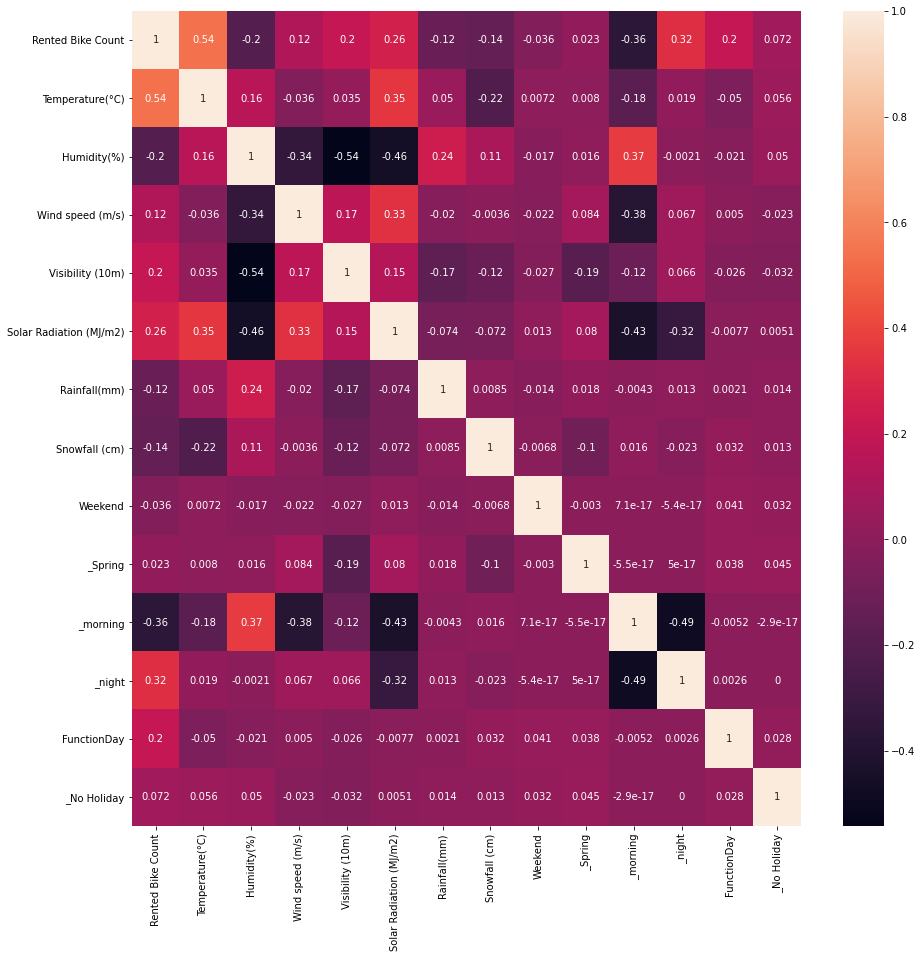

In [37]:
plt.figure(figsize=(15,15))
sns.heatmap(bikeData_feats_e32.corr(),annot=True)

#### Experiment 3

Reduce some more  features which are showing linearity near to 5

In [39]:
bikeData_feats_e33 = bikeData_feats.drop(['_Summer', '_Winter',\
                                          'Dew point temperature(°C)',\
                                          'Humidity(%)','_night'],axis=1)

In [40]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e32,Target_Variable,"BIKE_LR_ALL_E33",
                                                              "Removed correlation near to |0.5|,\
                                                               base BIKE_LR_ALL_E32",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Weekend', '_Spring', '_morning', '_night',
       'FunctionDay', '_No Holiday'],
      dtype='object')


In [41]:
result_table_e3_set.tail()

Model_Name Data_Type  \
1  BIKE_LR_ALL_E31_Train     Train   
2   BIKE_LR_ALL_E32_Test      Test   
3  BIKE_LR_ALL_E32_Train     Train   
4   BIKE_LR_ALL_E33_Test      Test   
5  BIKE_LR_ALL_E33_Train     Train   

                                             Remarks  R-squared  \
1  All variables, no tranformation,              ...   0.569750   
2  Base = BIKE_LR_ALL_E32,                       ...   0.545204   
3  Base = BIKE_LR_ALL_E32,                       ...   0.545204   
4  Removed correlation near to |0.5|,            ...   0.545204   
5  Removed correlation near to |0.5|,            ...   0.545204   

   Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
1        0.568624       2.013302   0.000000e+00  34174.968769  181442.188242   
2        0.544238       2.009292  9.954178e-294  17133.796207  193099.616332   
3        0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   
4        0.544238       2.009292  9.954178e-294  17133.796207  193099.616332   
5        0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   

         RMSE         MAE  
1  425.960313  317.537365  
2  439.431014  331.241346  
3  437.942405  324.923807  
4  439.431014  331.241346  
5  437.942405  324.923807

***Observation: No Improvement has been observed from Experiment 32***

#### Experiment 4

Lets Scale the Data

In [236]:
bikeData_feats_e34,var_names = standardScale_dataframe(bikeData_feats)

Rented Bike Count_std
Hour_std
Temperature(�C)_std
Humidity(%)_std
Wind speed (m/s)_std
Visibility (10m)_std
Dew point temperature(�C)_std
Solar Radiation (MJ/m2)_std
Rainfall(mm)_std
Snowfall (cm)_std
Weekend_std
_Spring_std
_Summer_std
_Winter_std
_evening_std
_morning_std
_night_std
_office_hours_std
FunctionDay_std
_No Holiday_std


In [237]:
bikeData_feats_e34_std = bikeData_feats_e34[var_names]


In [233]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e34_std,['Rented Bike Count_std'],"BIKE_LR_ALL_E34",
                                                              "input and output variable scaled",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Hour_std', 'Temperature(�C)_std', 'Humidity(%)_std',
       'Wind speed (m/s)_std', 'Visibility (10m)_std',
       'Dew point temperature(�C)_std', 'Solar Radiation (MJ/m2)_std',
       'Rainfall(mm)_std', 'Snowfall (cm)_std', 'Weekend_std', '_Spring_std',
       '_Summer_std', '_Winter_std', '_evening_std', '_morning_std',
       '_night_std', '_office_hours_std', 'FunctionDay_std',
       '_No Holiday_std'],
      dtype='object')


In [45]:
result_table_e3_set.tail()

Model_Name Data_Type  \
3  BIKE_LR_ALL_E32_Train     Train   
4   BIKE_LR_ALL_E33_Test      Test   
5  BIKE_LR_ALL_E33_Train     Train   
6   BIKE_LR_ALL_E34_Test      Test   
7  BIKE_LR_ALL_E34_Train     Train   

                                             Remarks  R-squared  \
3  Base = BIKE_LR_ALL_E32,                       ...   0.545204   
4  Removed correlation near to |0.5|,            ...   0.545204   
5  Removed correlation near to |0.5|,            ...   0.545204   
6                   input and output variable scaled   0.569750   
7                   input and output variable scaled   0.569750   

   Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
3        0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   
4        0.544238       2.009292  9.954178e-294  17133.796207  193099.616332   
5        0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   
6        0.568624       2.013302   0.000000e+00     27.523096       0.436488   
7        0.568624       2.013302   0.000000e+00     27.523096       0.436186   

         RMSE         MAE  
3  437.942405  324.923807  
4  439.431014  331.241346  
5  437.942405  324.923807  
6    0.660672    0.503494  
7    0.660444    0.492336

In [46]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Rented Bike Count_std   R-squared:                       0.570
Model:                               OLS   Adj. R-squared:                  0.569
Method:                    Least Squares   F-statistic:                     506.1
Date:                   Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                           01:51:48   Log-Likelihood:                -6157.1
No. Observations:                   6132   AIC:                         1.235e+04
Df Residuals:                       6115   BIC:                         1.246e+04
Df Model:                             16                                         
Covariance Type:               nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0069      0.008      0.814      0.416      -0.010       0.023
Temperature(°C)_std               0.4452      0.081      5.477      0.000       0.286       0.605
Humidity(%)_std                  -0.2983      0.039     -7.681      0.000      -0.374      -0.222
Wind speed (m/s)_std              0.0546      0.010      5.562      0.000       0.035       0.074
Visibility (10m)_std             -0.0141      0.011     -1.279      0.201      -0.036       0.008
Dew point temperature(°C)_std     0.0846      0.093      0.910      0.363      -0.098       0.267
Solar Radiation (MJ/m2)_std       0.0723      0.016      4.618      0.000       0.042       0.103
Rainfall(mm)_std                 -0.0850      0.008    -10.217      0.000      -0.101      -0.069
Snowfall (cm)_std                 0.0241      0.009      2.640      0.008       0.006       0.042
Weekend_std                      -0.0592      0.008     -6.972      0.000      -0.076      -0.043
_Spring_std                      -0.1192      0.011    -10.787      0.000      -0.141      -0.098
_Summer_std                      -0.1373      0.014    -10.027      0.000      -0.164      -0.110
_Winter_std                      -0.2162      0.016    -13.875      0.000      -0.247      -0.186
_morning_std                      0.0487      0.015      3.303      0.001       0.020       0.078
_night_std                        0.3664      0.014     26.852      0.000       0.340       0.393
FunctionDay_std                   0.2685      0.009     30.058      0.000       0.251       0.286
_No Holiday_std                   0.0467      0.009      5.477      0.000       0.030       0.063
==============================================================================
Omnibus:                      816.820   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1438.526
Skew:                           0.879   Prob(JB):                         0.00
Kurtosis:                       4.594   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Experiment 5

No Scaling of Target Variable

In [238]:
bikeData_feats_e35_std = bikeData_feats_e34[var_names]
bikeData_feats_e35_std.drop('Rented Bike Count_std', axis=1, inplace=True)
bikeData_feats_e35_std = pd.concat([bikeData_feats_e35_std,bikeData['Rented Bike Count']],axis=1)

bikeData_feats_e35_std.head(3)

Hour_std  Temperature(�C)_std  Humidity(%)_std  Wind speed (m/s)_std  \
0 -1.661325            -1.513957        -1.042483              0.458476   
1 -1.516862            -1.539074        -0.993370             -0.892561   
2 -1.372399            -1.580936        -0.944257             -0.699556   

   Visibility (10m)_std  Dew point temperature(�C)_std  \
0              0.925871                      -1.659605   
1              0.925871                      -1.659605   
2              0.925871                      -1.667262   

   Solar Radiation (MJ/m2)_std  Rainfall(mm)_std  Snowfall (cm)_std  \
0                    -0.655132           -0.1318          -0.171891   
1                    -0.655132           -0.1318          -0.171891   
2                    -0.655132           -0.1318          -0.171891   

   Weekend_std  _Spring_std  _Summer_std  _Winter_std  _evening_std  \
0    -0.631243    -0.580514    -0.580514     1.748015     -0.447214   
1    -0.631243    -0.580514    -0.580514     1.748015     -0.447214   
2    -0.631243    -0.580514    -0.580514     1.748015     -0.447214   

   _morning_std  _night_std  _office_hours_std  FunctionDay_std  \
0     -0.377964   -0.447214          -0.641689          0.18668   
1     -0.377964   -0.447214          -0.641689          0.18668   
2     -0.377964   -0.447214          -0.641689          0.18668   

   _No Holiday_std  Rented Bike Count  
0         0.227757                254  
1         0.227757                204  
2         0.227757                173

In [239]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e35_std,
                                                              ['Rented Bike Count'],"BIKE_LR_ALL_E35",
                                                              "input and output variable scaled",
                                                               result_table_e3_set,0.3,123)

Index(['const', 'Hour_std', 'Temperature(�C)_std', 'Humidity(%)_std',
       'Wind speed (m/s)_std', 'Visibility (10m)_std',
       'Dew point temperature(�C)_std', 'Solar Radiation (MJ/m2)_std',
       'Rainfall(mm)_std', 'Snowfall (cm)_std', 'Weekend_std', '_Spring_std',
       '_Summer_std', '_Winter_std', '_evening_std', '_morning_std',
       '_night_std', '_office_hours_std', 'FunctionDay_std',
       '_No Holiday_std'],
      dtype='object')


In [240]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     477.5
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        07:46:00   Log-Likelihood:                -45622.
No. Observations:                6132   AIC:                         9.128e+04
Df Residuals:                    6112   BIC:                         9.142e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           707.5715      5.271    134.233      0.000     697.238     717.905
Hour_std                        -26.7959     23.812     -1.125      0.261     -73.477      19.885
Temperature(�C)_std             134.6636     51.476      2.616      0.009      33.752     235.575
Humidity(%)_std                -222.4286     24.311     -9.149      0.000    -270.087    -174.770
Wind speed (m/s)_std             11.3103      6.202      1.824      0.068      -0.847      23.468
Visibility (10m)_std              8.6461      6.900      1.253      0.210      -4.879      22.172
Dew point temperature(�C)_std   194.0787     58.517      3.317      0.001      79.365     308.792
Solar Radiation (MJ/m2)_std      12.9538     10.411      1.244      0.213      -7.455      33.363
Rainfall(mm)_std                -59.3289      5.205    -11.399      0.000     -69.532     -49.126
Snowfall (cm)_std                12.7882      5.693      2.246      0.025       1.628      23.948
Weekend_std                     -37.3976      5.299     -7.057      0.000     -47.786     -27.009
_Spring_std                     -66.2526      6.897     -9.606      0.000     -79.773     -52.732
_Summer_std                     -71.1658      8.542     -8.331      0.000     -87.912     -54.420
_Winter_std                    -153.4022      9.727    -15.771      0.000    -172.471    -134.334
_evening_std                    258.4687     20.105     12.856      0.000     219.055     297.882
_morning_std                    121.5517      7.933     15.322      0.000     106.000     137.104
_night_std                      225.4214     25.106      8.979      0.000     176.206     274.637
_office_hours_std                76.5526     17.031      4.495      0.000      43.166     109.939
FunctionDay_std                 169.7758      5.574     30.457      0.000     158.848     180.703
_No Holiday_std                  27.9912      5.326      5.256      0.000      17.551      38.432
==============================================================================
Omnibus:                      678.582   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1220.210
Skew:                           0.745   Prob(JB):                    1.08e-265
Kurtosis:                       4.598   Cond. No.                         27.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [241]:
result_table_e3_set.tail(20)

Model_Name Data_Type  \
0        BIKE_LR_ALL_E32_Test      Test   
1       BIKE_LR_ALL_E32_Train     Train   
2        BIKE_LR_ALL_E33_Test      Test   
3       BIKE_LR_ALL_E33_Train     Train   
4    BIKE_LR_STD_RED_E36_Test      Test   
5   BIKE_LR_STD_RED_E36_Train     Train   
6    BIKE_LR_STD_VIF_E37_Test      Test   
7   BIKE_LR_STD_VIF_E37_Train     Train   
8        BIKE_LR_ALL_E31_Test      Test   
9       BIKE_LR_ALL_E31_Train     Train   
10       BIKE_LR_ALL_E34_Test      Test   
11      BIKE_LR_ALL_E34_Train     Train   
12       BIKE_LR_ALL_E35_Test      Test   
13      BIKE_LR_ALL_E35_Train     Train   

                                              Remarks  R-squared  \
0   Base = BIKE_LR_ALL_E32,                       ...   0.545204   
1   Base = BIKE_LR_ALL_E32,                       ...   0.545204   
2   Removed correlation near to |0.5|,            ...   0.545204   
3   Removed correlation near to |0.5|,            ...   0.545204   
4   input and output variable scaled              ...   0.537083   
5   input and output variable scaled              ...   0.537083   
6                                 after VIF treatment   0.569692   
7                                 after VIF treatment   0.569692   
8   All variables, no tranformation,              ...   0.597506   
9   All variables, no tranformation,              ...   0.597506   
10                   input and output variable scaled   0.597506   
11                   input and output variable scaled   0.597506   
12                   input and output variable scaled   0.597506   
13                   input and output variable scaled   0.597506   

    Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
0         0.544238       2.009292  9.954178e-294  17133.796207  193099.616332   
1         0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   
2         0.544238       2.009292  9.954178e-294  17133.796207  193099.616332   
3         0.544238       2.009292  9.954178e-294  17133.796207  191793.549980   
4         0.536251       2.005816  2.334175e-272      4.086600  197037.503489   
5         0.536251       2.005816  2.334175e-272      4.086600  195218.445110   
6         0.568636       2.013667   0.000000e+00      4.488609  181642.973930   
7         0.568636       2.013667   0.000000e+00      4.488609  181466.782055   
8         0.596254       2.023010  1.083288e-265  33978.113374  163841.693774   
9         0.596254       2.023010  1.083288e-265  33978.113374  169737.350888   
10        0.596254       2.023010  1.083288e-265     27.853776       0.393875   
11        0.596254       2.023010  1.083288e-265     27.853776       0.408048   
12        0.596254       2.023010  1.083288e-265     27.853776  163841.693774   
13        0.596254       2.023010  1.083288e-265     27.853776  169737.350888   

          RMSE         MAE  
0   439.431014  331.241346  
1   437.942405  324.923807  
2   439.431014  331.241346  
3   437.942405  324.923807  
4   443.889067  335.326844  
5   441.835314  329.457947  
6   426.195934  325.139974  
7   425.989181  317.772080  
8   404.773633  311.850464  
9   411.991931  308.797194  
10    0.627594    0.483519  
11    0.638786    0.478785  
12  404.773633  311.850464  
13  411.991931  308.797194

#### 3.3.2.1 Condition Number

***The Conditions Number has been reduced after the scaling of the data***

In [51]:
print("Condition Number is now normal after the scale transformations = ",lr_model.condition_number)

Condition Number is now normal after the scale transformations =  27.523096338828402


#### 3.3.3 Existence of linear relationship

The independent variables must have a linear relationship with the dependent 
variable

In [52]:
import math

def plot_residual_linearity(residual,predictors,figsize=(10,6)):
    N = len(predictors.columns)
    rows = math.ceil(N/3)
    if rows == 0:
        return
    
    fig, axs = plt.subplots(rows,3, figsize=figsize)
    fig.subplots_adjust(hspace = .2, wspace=.2)

    axs = axs.ravel()
    
    i = 0
    for pred in predictors.columns:
        sns.scatterplot(x = predictors[pred],y=residual,ax=axs[i] )
        i +=1
        

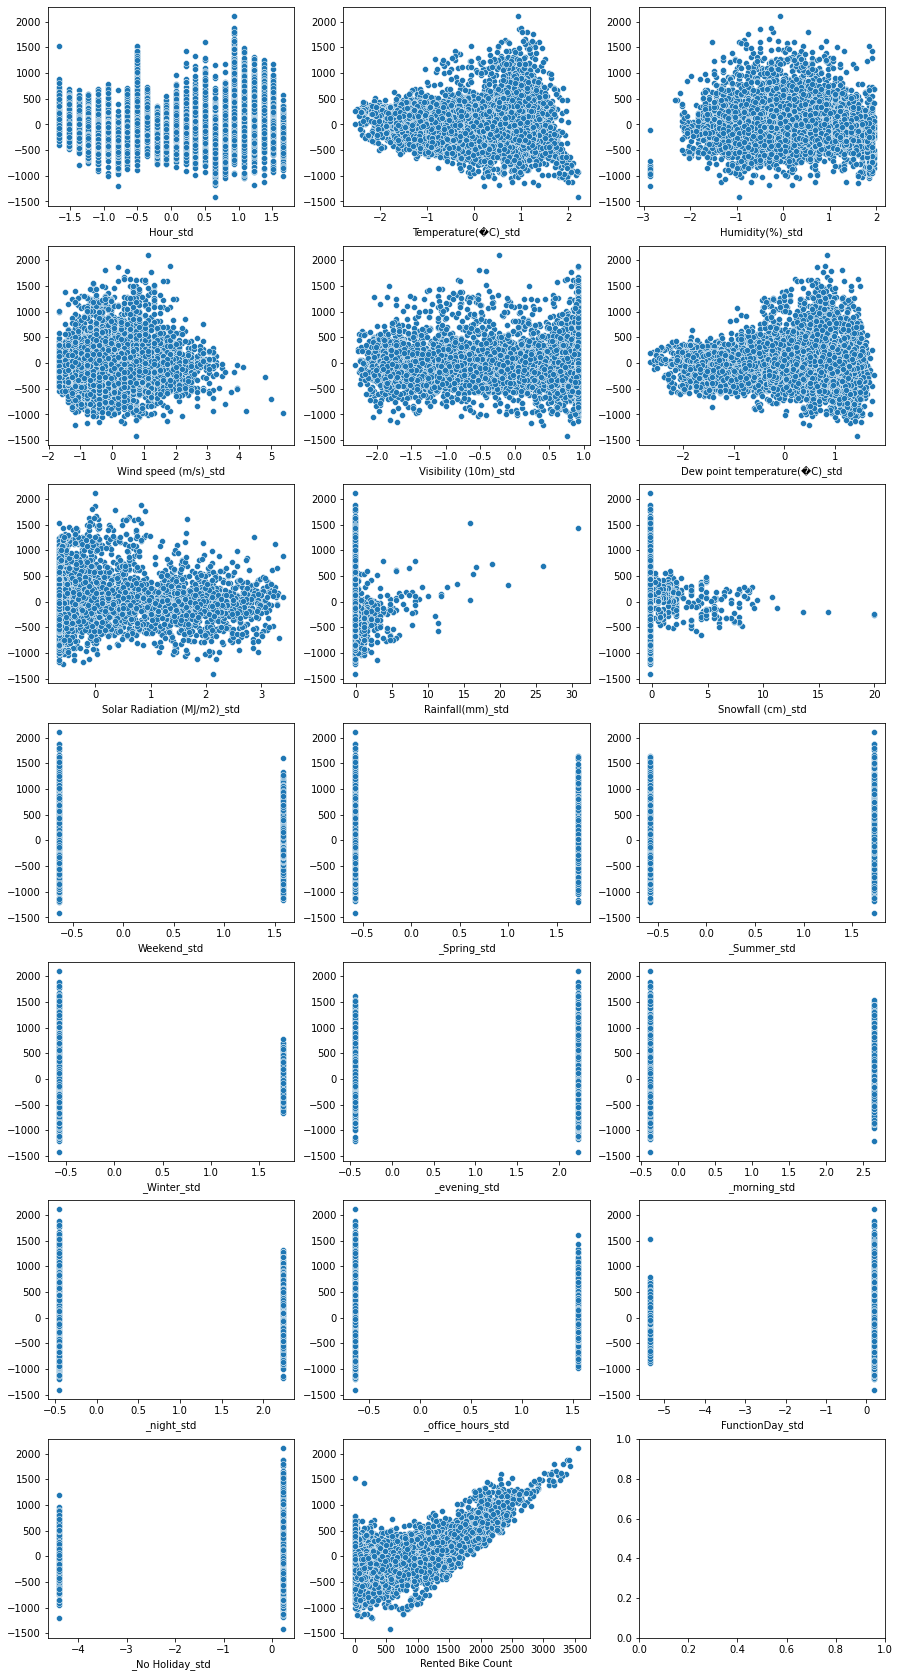

In [242]:

plot_residual_linearity(lr_model.resid,bikeData_feats_e35_std,figsize=(15, 30))

***Observation: There is no specific pattern observed between predictors and residuals***

A scatter plot depicting no pattern indicates that the variable has a linear relationship with the response variable. 

we see a random pattern in all the plots of independent. Hence, we may say that, the predictors are linearly related with the response variable

Relation is seen only with the target variable as it was present in the input dataframe.

#### 3.3.4 Assumption of autocorrelation


Assumption of autocorrelation is violated when residuals are correlated within 
themselves, i.e. they are serially correlated

To test whether the error terms are autocorrelated,we do Durbin-Watson test

In [54]:
statsmodels.stats.stattools.durbin_watson(lr_model.resid, axis=0)

2.0133018451770592

If the value is near to 2, then there is No autocorrelation

#### 3.3.5 Homoscedasticity assumption

In [55]:
lm,lmpval,fval,f_pval = statsmodels.stats.diagnostic.het_breuschpagan(lr_model.resid,lr_model.model.exog)
print(lmpval)

6.803829082895821e-138


There are two big reasons why we need homoscedasticity: While heteroscedasticity does not cause bias in the coefficient estimates, it does make them less precise. ... This effect occurs because heteroscedasticity increases the variance of the coefficient estimates but the OLS procedure does not detect this increase.

***Observation: As per the test, the error terms are heteroskedastic***

#### Experiment 6

Trying to redude heteroskedasticity by removing RainFall and Snow Fall from the model, as the above scatter plot have shown a funnel like pattern.

In [56]:
bikeData.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Hour_bkt', 'Weekend'],
      dtype='object')

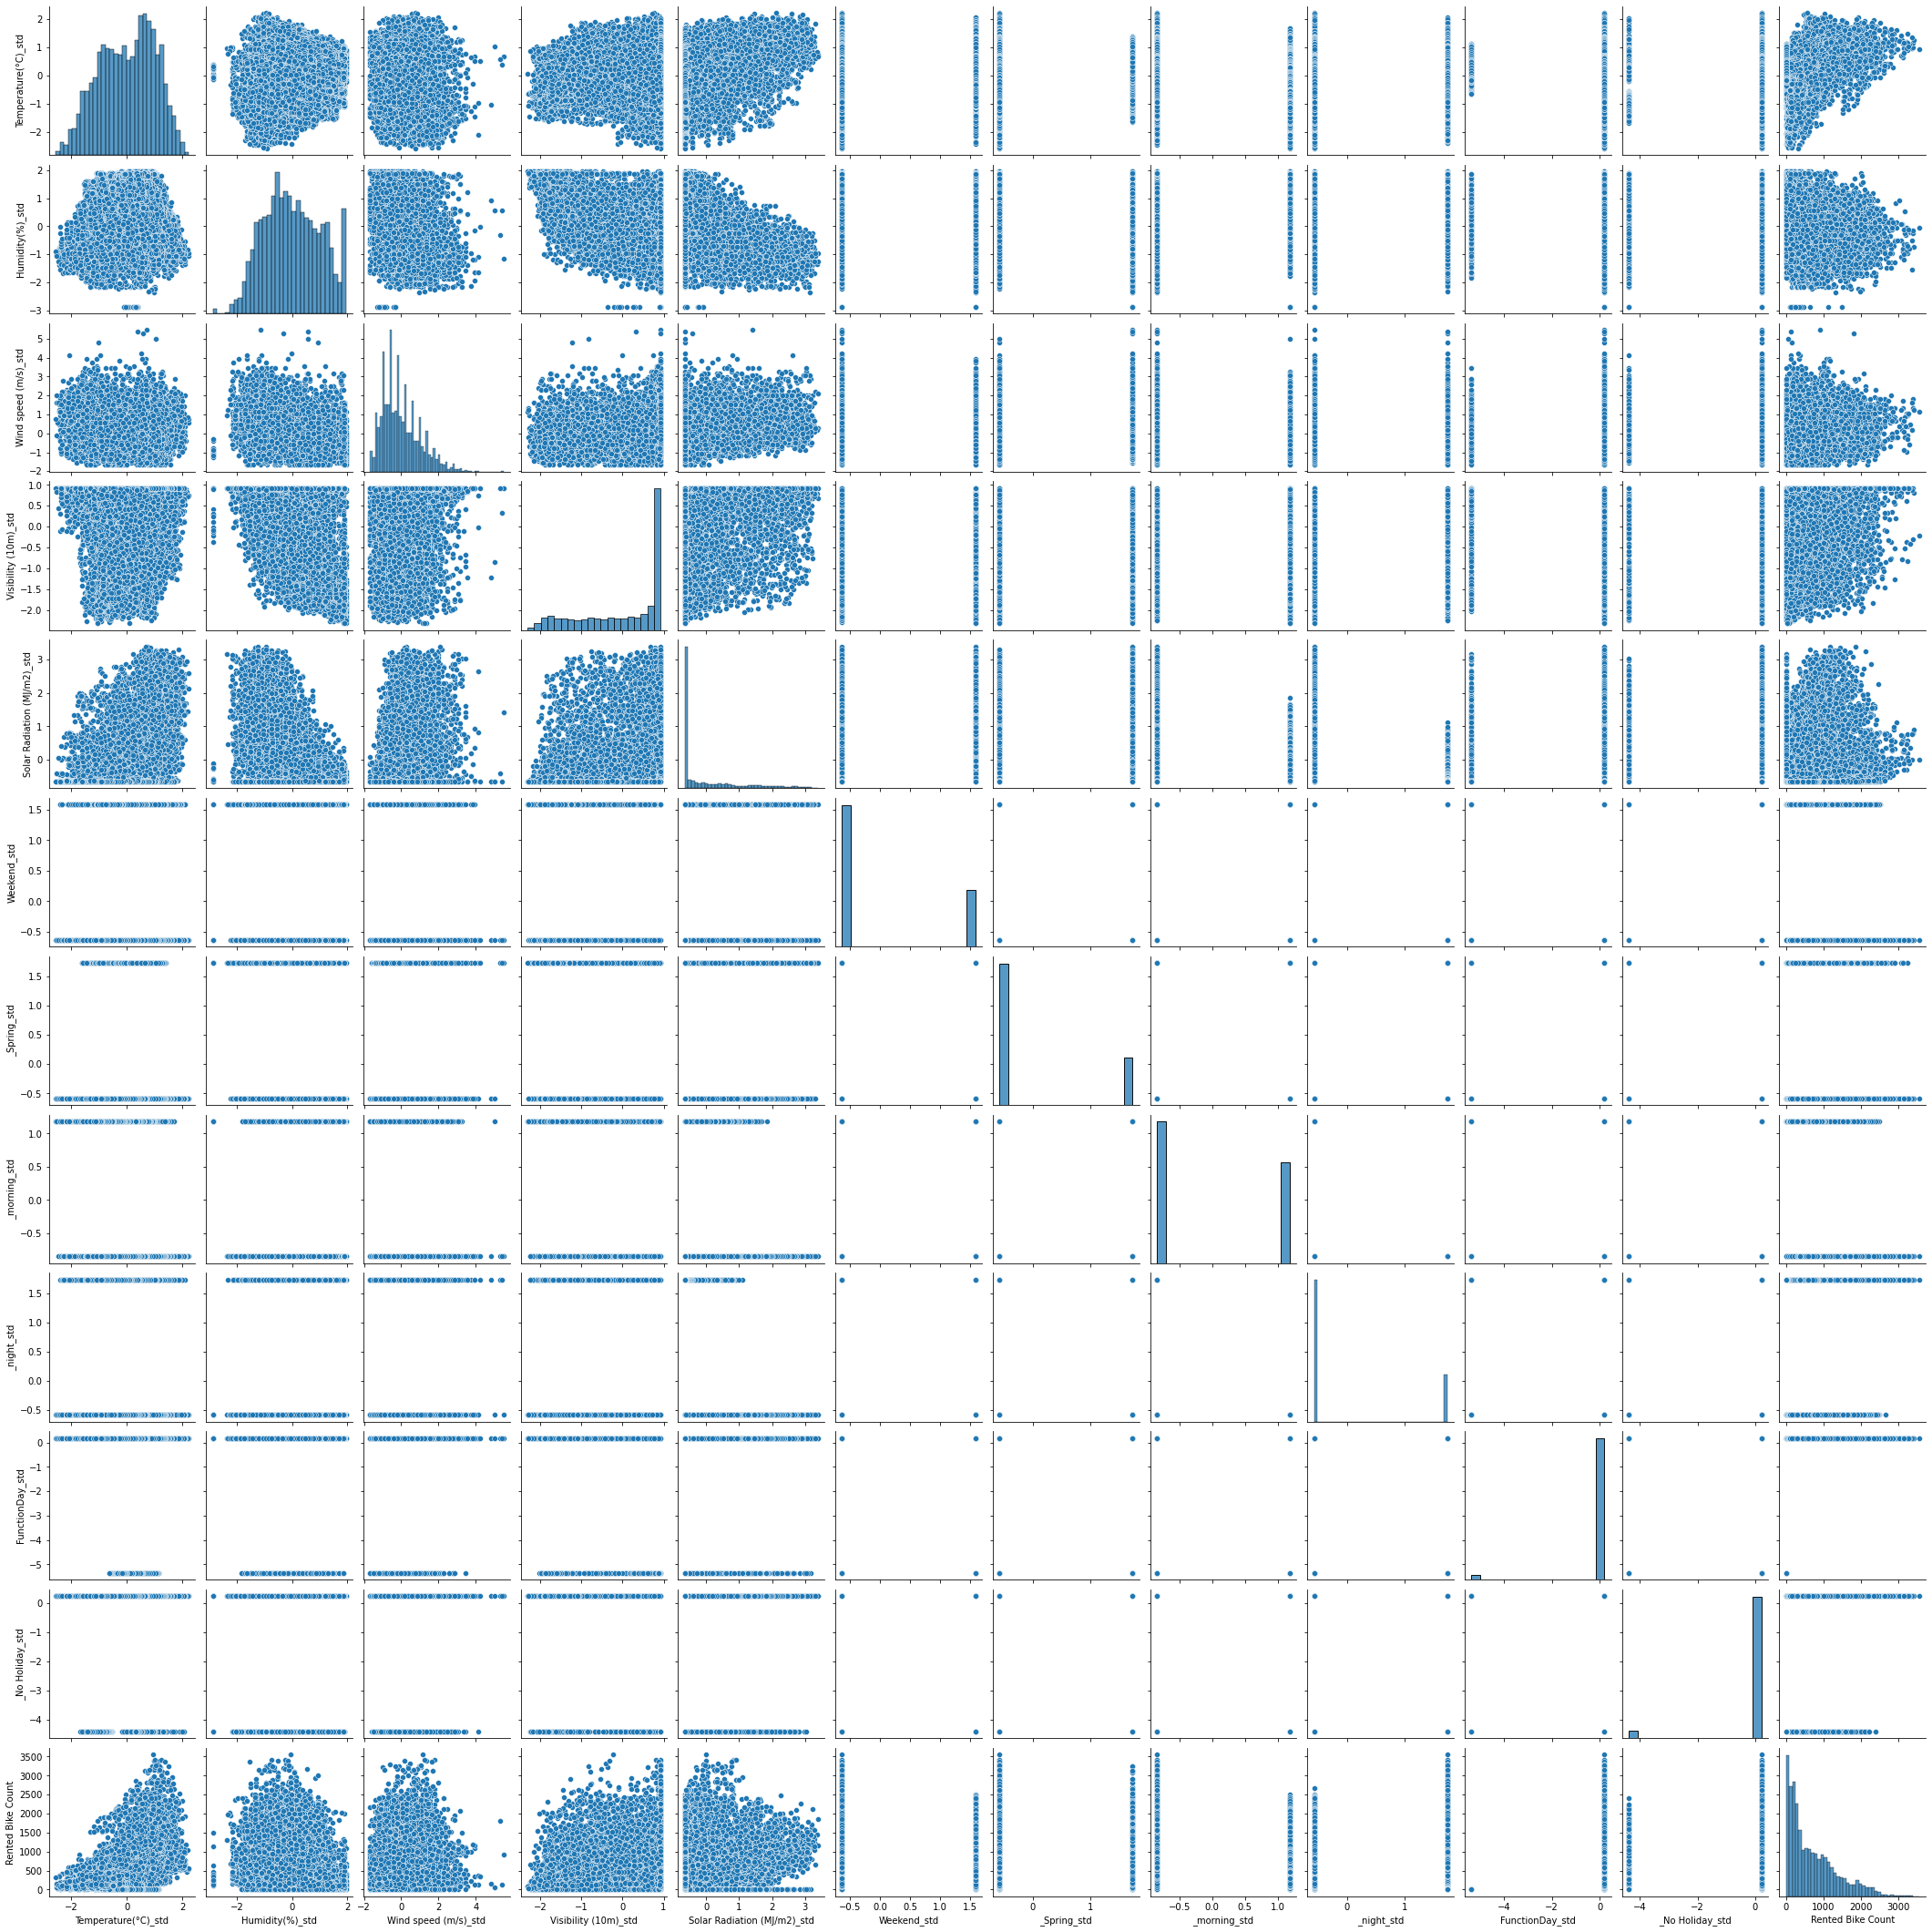

In [58]:
bikeData_feats_e36_std = bikeData_feats_e35_std[['Temperature(°C)_std', 'Humidity(%)_std', 'Wind speed (m/s)_std',
       'Visibility (10m)_std', 
       'Solar Radiation (MJ/m2)_std', 
       'Weekend_std', '_Spring_std', 
       '_morning_std', '_night_std', 'FunctionDay_std', '_No Holiday_std',
       'Rented Bike Count']]
sns.pairplot(bikeData_feats_e36_std)

In [59]:
# Fit the Model and store the results
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e36_std,
                                                              ['Rented Bike Count'],"BIKE_LR_STD_RED_E36",
                                                              "input and output variable scaled\
                                                               reduced few variables",
                                                               result_table_e3_set,0.3,123)

result_table_e3_set.tail()

Index(['const', 'Temperature(°C)_std', 'Humidity(%)_std',
       'Wind speed (m/s)_std', 'Visibility (10m)_std',
       'Solar Radiation (MJ/m2)_std', 'Weekend_std', '_Spring_std',
       '_morning_std', '_night_std', 'FunctionDay_std', '_No Holiday_std'],
      dtype='object')


Model_Name Data_Type  \
7       BIKE_LR_ALL_E34_Train     Train   
8        BIKE_LR_ALL_E35_Test      Test   
9       BIKE_LR_ALL_E35_Train     Train   
10   BIKE_LR_STD_RED_E36_Test      Test   
11  BIKE_LR_STD_RED_E36_Train     Train   

                                              Remarks  R-squared  \
7                    input and output variable scaled   0.569750   
8                    input and output variable scaled   0.569750   
9                    input and output variable scaled   0.569750   
10  input and output variable scaled              ...   0.537083   
11  input and output variable scaled              ...   0.537083   

    Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
7         0.568624       2.013302   0.000000e+00     27.523096       0.436186   
8         0.568624       2.013302   0.000000e+00     27.523096  181567.614085   
9         0.568624       2.013302   0.000000e+00     27.523096  181442.188242   
10        0.536251       2.005816  2.334175e-272      4.086600  197037.503489   
11        0.536251       2.005816  2.334175e-272      4.086600  195218.445110   

          RMSE         MAE  
7     0.660444    0.492336  
8   426.107515  324.733638  
9   425.960313  317.537365  
10  443.889067  335.326844  
11  441.835314  329.457947

In [60]:
lm,lmpval,fval,f_pval = statsmodels.stats.diagnostic.het_breuschpagan(lr_model.resid,lr_model.model.exog)
print(lmpval)

3.2689464371657073e-139


***Observation: Experiment did not improve the hetroskedasticity, and also the model performance have been reduced. So lets leave it here.***

#### 3.3.6 The error terms must follow normal distribution


<AxesSubplot:ylabel='Density'>

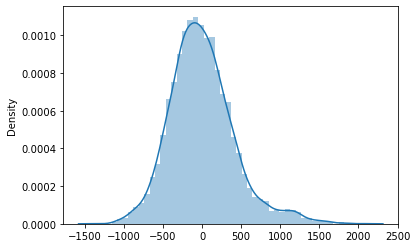

In [250]:
residuals = lr_model.resid
sns.distplot(residuals,kde=True)

In [249]:
JB,JBpv,skew,kurt =sm.stats.stattools.jarque_bera(residuals,axis=0)
JBpv

2.334175058286197e-272

##### Experiment 7

In [243]:

bikeData_feats_e37_std = bikeData_feats_e35_std.copy()
bikeData_feats_e37_std = bikeData_feats_e37_std.drop('Rented Bike Count', axis=1)
for i in range(len(bikeData_feats_e37_std.columns)):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(bikeData_feats_e37_std.values,i) for i in range(bikeData_feats_e37_std.shape[1])]
    vif['Features'] = bikeData_feats_e37_std.columns
    vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)
    
    multi = vif[vif.VIF_Factor > 10]
    
    if (multi.empty == False):
        df_sorted = multi.sort_values(by = 'VIF_Factor',ascending = False)
        bikeData_feats_e37_std = bikeData_feats_e37_std.drop(df_sorted.Features.iloc[0], axis=1)
    else:
        print(vif)
        break;


    VIF_Factor                     Features
0     1.335908                     Hour_std
1     5.298687          Temperature(�C)_std
2     2.726153              Humidity(%)_std
3     1.357576         Wind speed (m/s)_std
4     1.705724         Visibility (10m)_std
5     3.709572  Solar Radiation (MJ/m2)_std
6     1.082121             Rainfall(mm)_std
7     1.115892            Snowfall (cm)_std
8     1.006999                  Weekend_std
9     1.718260                  _Spring_std
10    2.636956                  _Summer_std
11    3.400353                  _Winter_std
12    1.629545                 _evening_std
13    1.205783                 _morning_std
14    2.914123            _office_hours_std
15    1.082482              FunctionDay_std
16    1.024980              _No Holiday_std


In [244]:
X = bikeData_feats_e37_std
X = sm.add_constant(X)
Y = bikeData['Rented Bike Count']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 123) 
lin_reg_model = sm.OLS(y_train,x_train).fit()
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     520.0
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        07:49:11   Log-Likelihood:                -45670.
No. Observations:                6132   AIC:                         9.138e+04
Df Residuals:                    6114   BIC:                         9.150e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         707.6678      5.312    133.224      0.000     697.255     718.081
Hour_std                      179.6652      6.172     29.112      0.000     167.567     191.764
Temperature(�C)_std           300.4334     12.250     24.525      0.000     276.419     324.448
Humidity(%)_std              -147.6736      8.833    -16.718      0.000    -164.990    -130.357
Wind speed (m/s)_std           10.4103      6.247      1.666      0.096      -1.836      22.657
Visibility (10m)_std           10.6469      6.941      1.534      0.125      -2.959      24.253
Solar Radiation (MJ/m2)_std    -2.1959     10.251     -0.214      0.830     -22.291      17.899
Rainfall(mm)_std              -61.7267      5.206    -11.857      0.000     -71.932     -51.522
Snowfall (cm)_std              11.4119      5.720      1.995      0.046       0.199      22.625
Weekend_std                   -38.6576      5.323     -7.263      0.000     -49.092     -28.223
_Spring_std                   -65.6372      6.945     -9.451      0.000     -79.253     -52.022
_Summer_std                   -67.1775      8.583     -7.827      0.000     -84.003     -50.352
_Winter_std                  -154.2970      9.802    -15.742      0.000    -173.512    -135.083
_evening_std                   86.6396      6.776     12.785      0.000      73.355      99.924
_morning_std                   73.2304      5.841     12.538      0.000      61.780      84.680
_office_hours_std             -51.5250      9.048     -5.694      0.000     -69.263     -33.787
FunctionDay_std               169.8385      5.616     30.241      0.000     158.829     180.848
_No Holiday_std                27.4781      5.366      5.121      0.000      16.959      37.997
==============================================================================
Omnibus:                      611.382   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1004.876
Skew:                           0.716   Prob(JB):                    6.22e-219
Kurtosis:                       4.371   Cond. No.                         4.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [245]:
# Fit the Model and store the results
bikeData_feats_e37_std = pd.concat([bikeData_feats_e37_std,bikeData['Rented Bike Count']],axis=1)
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e37_std,
                                                              ['Rented Bike Count'],"BIKE_LR_STD_VIF_E37",
                                                              "after VIF treatment",
                                                               result_table_e3_set,0.3,123)

result_table_e3_set.tail()

Index(['const', 'Hour_std', 'Temperature(�C)_std', 'Humidity(%)_std',
       'Wind speed (m/s)_std', 'Visibility (10m)_std',
       'Solar Radiation (MJ/m2)_std', 'Rainfall(mm)_std', 'Snowfall (cm)_std',
       'Weekend_std', '_Spring_std', '_Summer_std', '_Winter_std',
       '_evening_std', '_morning_std', '_office_hours_std', 'FunctionDay_std',
       '_No Holiday_std'],
      dtype='object')


Model_Name Data_Type                           Remarks  \
9       BIKE_LR_ALL_E34_Train     Train  input and output variable scaled   
10       BIKE_LR_ALL_E35_Test      Test  input and output variable scaled   
11      BIKE_LR_ALL_E35_Train     Train  input and output variable scaled   
12   BIKE_LR_STD_VIF_E37_Test      Test               after VIF treatment   
13  BIKE_LR_STD_VIF_E37_Train     Train               after VIF treatment   

    R-squared  Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No  \
9    0.597506        0.596254       2.023010  1.083288e-265     27.853776   
10   0.597506        0.596254       2.023010  1.083288e-265     27.853776   
11   0.597506        0.596254       2.023010  1.083288e-265     27.853776   
12   0.591142        0.590005       2.020755  6.223218e-219      4.870427   
13   0.591142        0.590005       2.020755  6.223218e-219      4.870427   

              MSE        RMSE         MAE  
9        0.408048    0.638786    0.478785  
10  163841.693774  404.773633  311.850464  
11  169737.350888  411.991931  308.797194  
12  167754.919594  409.578954  318.990340  
13  172420.977154  415.236050  315.672531

#### Experiment 8

Remove the insignificant variables identified from the model statistics

In [252]:
bikeData_feats_e38_std = bikeData_feats_e37_std.drop(['Solar Radiation (MJ/m2)_std','Visibility (10m)_std','Wind speed (m/s)_std'],axis=1)

In [271]:
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e38_std,
                                                              ['Rented Bike Count'],"BIKE_LR_STD_VIF_E38",
                                                              "after VIF treatment, removed insignificant",
                                                               result_table_e3_set,0.3,123)

result_table_e3_set.tail()

Index(['const', 'Hour_std', 'Temperature(�C)_std', 'Humidity(%)_std',
       'Rainfall(mm)_std', 'Snowfall (cm)_std', 'Weekend_std', '_Spring_std',
       '_Summer_std', '_Winter_std', '_evening_std', '_morning_std',
       '_office_hours_std', 'FunctionDay_std', '_No Holiday_std'],
      dtype='object')


Model_Name Data_Type  \
11      BIKE_LR_ALL_E35_Train     Train   
12   BIKE_LR_STD_VIF_E37_Test      Test   
13  BIKE_LR_STD_VIF_E37_Train     Train   
14   BIKE_LR_STD_VIF_E38_Test      Test   
15  BIKE_LR_STD_VIF_E38_Train     Train   

                                       Remarks  R-squared  Adj. R-squared  \
11            input and output variable scaled   0.597506        0.596254   
12                         after VIF treatment   0.591142        0.590005   
13                         after VIF treatment   0.591142        0.590005   
14  after VIF treatment, removed insignificant   0.590766        0.589830   
15  after VIF treatment, removed insignificant   0.590766        0.589830   

    Durbin_Watson        JB_Prob  Condition_No            MSE        RMSE  \
11       2.023010  1.083288e-265     27.853776  169737.350888  411.991931   
12       2.020755  6.223218e-219      4.870427  167754.919594  409.578954   
13       2.020755  6.223218e-219      4.870427  172420.977154  415.236050   
14       2.020015  2.744078e-221      4.268395  167607.017356  409.398360   
15       2.020015  2.744078e-221      4.268395  172579.429291  415.426804   

           MAE  
11  308.797194  
12  318.990340  
13  315.672531  
14  318.907936  
15  316.012265

In [258]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     630.7
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        08:01:02   Log-Likelihood:                -45673.
No. Observations:                6132   AIC:                         9.138e+04
Df Residuals:                    6117   BIC:                         9.148e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 707.6140      5.313    133.188      0.000     697.199     718.029
Hour_std              181.0691      6.075     29.803      0.000     169.159     192.979
Temperature(�C)_std   298.1737     11.496     25.937      0.000     275.637     320.710
Humidity(%)_std      -156.2957      6.471    -24.152      0.000    -168.982    -143.610
Rainfall(mm)_std      -61.4485      5.197    -11.824      0.000     -71.636     -51.261
Snowfall (cm)_std      11.3811      5.710      1.993      0.046       0.187      22.575
Weekend_std           -39.3237      5.316     -7.397      0.000     -49.745     -28.903
_Spring_std           -66.7938      6.634    -10.069      0.000     -79.798     -53.790
_Summer_std           -65.3408      8.544     -7.647      0.000     -82.090     -48.591
_Winter_std          -156.2766      9.610    -16.262      0.000    -175.115    -137.438
_evening_std           87.4922      6.518     13.423      0.000      74.714     100.270
_morning_std           72.1996      5.761     12.533      0.000      60.907      83.493
_office_hours_std     -53.0726      6.465     -8.209      0.000     -65.747     -40.398
FunctionDay_std       169.5462      5.616     30.191      0.000     158.537     180.555
_No Holiday_std        27.2335      5.366      5.075      0.000      16.715      37.752
==============================================================================
Omnibus:                      617.734   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1015.724
Skew:                           0.722   Prob(JB):                    2.74e-221
Kurtosis:                       4.374   Cond. No.                         4.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

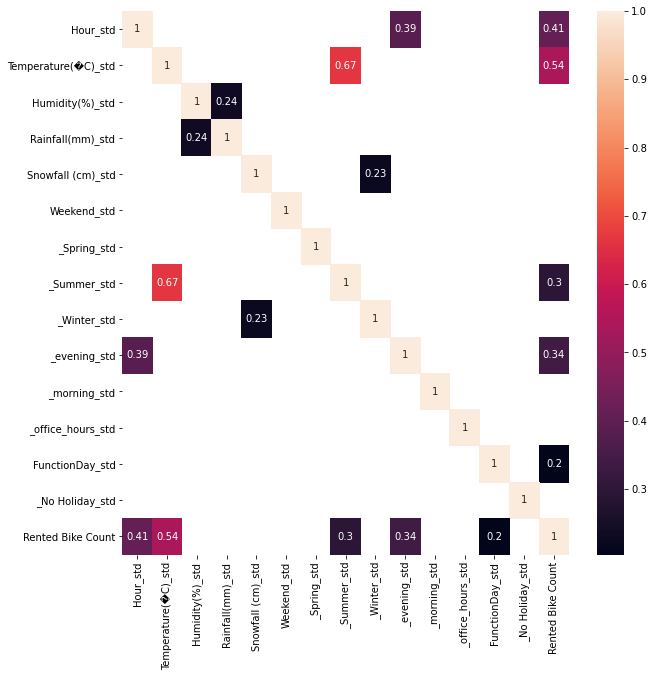

In [269]:
corr = bikeData_feats_e38_std.corr()
corr= corr[corr>0.2]
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot = True)

#### Experiment 9

In [277]:
bikeData_feats_e39_std = bikeData_feats_e38_std.drop(['_Summer_std','Humidity(%)_std','FunctionDay_std','Weekend_std'],axis=1)

In [278]:
result_table_e3_set,lr_model,num_train  = lr_model_experiment(bikeData_feats_e39_std,
                                                              ['Rented Bike Count'],"BIKE_LR_STD_VIF_E39",
                                                              "after VIF treatment, removed insignificant\
                                                              removed collenear variable > 0.6",
                                                               result_table_e3_set,0.3,123)
result_table_e3_set.tail()

Index(['const', 'Hour_std', 'Temperature(�C)_std', 'Rainfall(mm)_std',
       'Snowfall (cm)_std', '_Spring_std', '_Winter_std', '_evening_std',
       '_morning_std', '_office_hours_std', '_No Holiday_std'],
      dtype='object')


Model_Name Data_Type  \
13  BIKE_LR_STD_VIF_E37_Train     Train   
14   BIKE_LR_STD_VIF_E38_Test      Test   
15  BIKE_LR_STD_VIF_E38_Train     Train   
16   BIKE_LR_STD_VIF_E39_Test      Test   
17  BIKE_LR_STD_VIF_E39_Train     Train   

                                              Remarks  R-squared  \
13                                after VIF treatment   0.591142   
14         after VIF treatment, removed insignificant   0.590766   
15         after VIF treatment, removed insignificant   0.590766   
16  after VIF treatment, removed insignificant    ...   0.486931   
17  after VIF treatment, removed insignificant    ...   0.486931   

    Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
13        0.590005       2.020755  6.223218e-219      4.870427  172420.977154   
14        0.589830       2.020015  2.744078e-221      4.268395  167607.017356   
15        0.589830       2.020015  2.744078e-221      4.268395  172579.429291   
16        0.486093       2.012665  9.558749e-121      3.379495  211688.376452   
17        0.486093       2.012665  9.558749e-121      3.379495  216368.121034   

          RMSE         MAE  
13  415.236050  315.672531  
14  409.398360  318.907936  
15  415.426804  316.012265  
16  460.096051  352.094803  
17  465.153868  349.315581

Model_Name Data_Type  \
11      BIKE_LR_ALL_E35_Train     Train   
12   BIKE_LR_STD_VIF_E37_Test      Test   
13  BIKE_LR_STD_VIF_E37_Train     Train   
14   BIKE_LR_STD_VIF_E38_Test      Test   
15  BIKE_LR_STD_VIF_E38_Train     Train   

                                              Remarks  R-squared  \
11                   input and output variable scaled   0.597506   
12                                after VIF treatment   0.591142   
13                                after VIF treatment   0.591142   
14  after VIF treatment, removed insignificant    ...   0.586854   
15  after VIF treatment, removed insignificant    ...   0.586854   

    Adj. R-squared  Durbin_Watson        JB_Prob  Condition_No            MSE  \
11        0.596254       2.023010  1.083288e-265     27.853776  169737.350888   
12        0.590005       2.020755  6.223218e-219      4.870427  167754.919594   
13        0.590005       2.020755  6.223218e-219      4.870427  172420.977154   
14        0.585976       2.021772  1.726324e-196      3.445593  169154.919742   
15        0.585976       2.021772  1.726324e-196      3.445593  174229.426759   

          RMSE         MAE  
11  411.991931  308.797194  
12  409.578954  318.990340  
13  415.236050  315.672531  
14  411.284475  320.690067  
15  417.407986  317.735456